In [1]:
"""
Example of building an autoencoder as a multi-layer
perceptron in PyTorch.
Noisy 1D spiral.
Demonstrates regularising data.

"""

import torch
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.optim as optim
import time

D:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


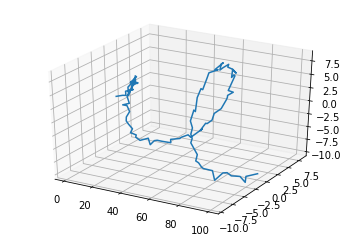

In [2]:
# Number of samples
n_samples=100

# Number of dimensions
nd=3

# Generate spiral cone
X=np.zeros([n_samples,nd])
for i in range(0,n_samples):
    X[i,0]=i
    X[i,1]=np.sqrt(i)*np.cos(i/9)
    X[i,2]=np.sqrt(i)*np.sin(i/9)
    
noise_sd=0.5
X+=np.random.normal(scale=noise_sd,size=[n_samples,nd])
    
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(X[:,0],X[:,1],X[:,2])
plt.show()

In [3]:
Xt=torch.tensor(X,dtype=torch.float32)

N_hidden=20  # Number of dimensions of hidden layer
N_latent=1   # Number of dimensions in latent space

# Use the nn package to define a model as a sequence of layers. 
# nn.Sequential is a Module which contains other Modules, 
# and applies them in sequence to produce its output. 
# Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
model = torch.nn.Sequential(
    torch.nn.Linear(nd, N_hidden),
    torch.nn.Sigmoid(),
    torch.nn.Linear(N_hidden, N_latent),
    torch.nn.Linear(N_latent, N_hidden),
    torch.nn.Sigmoid(),
    torch.nn.Linear(N_hidden,nd)
)

# Initialise the weights to random values
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        m.weight.data.uniform_(-1,1)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

# Mean square error loss
loss_fn = torch.nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Number of samples per batch
# Must divide number of samples exactly
batch_size=25

# Number of complete passes through all data
n_epochs=15000

In [4]:
start_time=time.perf_counter()

for ep in range(n_epochs):
    # Randomly permute the data so it is presented
    # in a different order in each epoch
    perm=np.random.permutation(n_samples)
    
    # Total loss is sum over all batches
    total_loss=0
    
    for b in range(round(n_samples/batch_size)):
        # Pick out the b-th chunk of the data
        batch_perm=perm[b*batch_size:(b+1)*batch_size]
        y_pred = model(Xt[batch_perm])
    
        loss = loss_fn(y_pred, Xt[batch_perm])
        total_loss+=loss.item()
   
        # Zero the gradients before running the backward pass.
        model.zero_grad()
    
        # Compute gradients. 
        loss.backward()
    
        # Use the optimizer to update the weights
        optimizer.step()
            
    if ((ep+1)%100==0):  # Print every 100th epoch
        print(ep+1, total_loss)
 
end_time=time.perf_counter()
print("Total time spent optimizing: {:0.1f}sec.".format(end_time-start_time))

100 3483.5181884765625
200 2706.350311279297
300 2089.6815490722656
400 1671.4503173828125
500 1344.8098754882812
600 1083.8966827392578
700 873.5009307861328
800 701.9119567871094
900 562.2286682128906
1000 449.35040283203125
1100 357.63813400268555
1200 268.85020446777344
1300 206.97243118286133
1400 161.36204147338867
1500 126.75293159484863
1600 100.4834098815918
1700 81.07465362548828
1800 67.02477073669434
1900 56.16670036315918
2000 48.11306619644165
2100 42.52997159957886
2200 36.43930768966675
2300 32.4384708404541
2400 28.23205041885376
2500 24.909926891326904
2600 22.395801544189453
2700 19.757814168930054
2800 17.396758317947388
2900 15.055405139923096
3000 13.160929918289185
3100 11.476217031478882
3200 10.104143381118774
3300 8.67264711856842
3400 7.619487762451172
3500 6.8148512840271
3600 5.708052277565002
3700 5.1295947432518005
3800 4.460329651832581
3900 3.9453964829444885
4000 3.500910699367523
4100 3.2458417415618896
4200 2.93570876121521
4300 2.5850622355937958
44

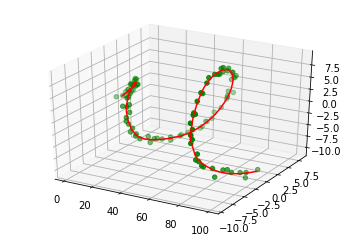

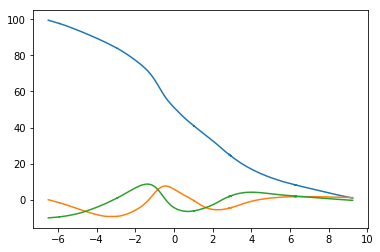

In [5]:
# Apply model to whole set
y_pred=model(Xt)
Y=y_pred.detach().numpy()
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.plot(X[:,0],X[:,1],X[:,2],color='green')
ax.scatter(X[:,0],X[:,1],X[:,2],color='green')
ax.plot(Y[:,0],Y[:,1],Y[:,2],color='red')
plt.show()

# To encode, use first modules in model:
y=model[0:3](Xt)
ynp=y.detach().numpy()

# To decode use the rest:
x_new=model[3:](y).detach().numpy()

plt.plot(ynp,x_new[:,0])
plt.plot(ynp,x_new[:,1])
plt.plot(ynp,x_new[:,2])
plt.show()